### Acknowledgements:

- Architecture: https://github.com/ravidziv/IDNNs

### Import packages

In [1]:
from __future__ import print_function
import IPython
import numpy as np
import pandas as pd
import keras
import itertools
import re
import os
import sys
import tensorflow as tf
import keras.backend as K
from mnist import MNIST
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix
from keras.initializers import TruncatedNormal
from keras.optimizers import adam
from tensorflow.examples.tutorials.mnist import input_data
from keras.utils.np_utils import to_categorical
import _pickle as cPickle
import multiprocessing
%matplotlib inline

Using TensorFlow backend.


In [2]:
from idnns.information import information_process  as inn
from idnns.plots import plot_figures as plt_fig
from idnns.networks.utils import data_shuffle
NUM_CORES = multiprocessing.cpu_count()

### Define Parameters

In [3]:
cov_net = 0
calc_information = True
run_in_parallel = False
num_ephocs = 10
learning_rate = 0.001
batch_size = 256
activation_function = 0
interval_accuracy_display = 499
save_grads = True
num_of_repeats = 1
calc_information_last = False
num_of_bins = 30
interval_information_display = 30
save_ws = False
inds = '[80]'
num_of_samples = 400
start_samples = 1
num_classes = 10
# The arch of the networks
layers_sizes = [[10,7,5,4,3]]
img_rows, img_cols = 28, 28

### Generic routine to plot data

In [4]:
def plot_data(data, random=0):
    # create a grid of 3x3 images
    for i in range(0, 9):
        # display random images from data sample
        if random:
            idx = np.random.randint(0,data.shape[0])
        else:
            idx = i
        pyplot.subplot(330 + 1 + i)
        pyplot.imshow(data[idx].reshape(28, 28), cmap=pyplot.get_cmap('gray'))
    # show the plot
    pyplot.show()

###  Load train/test data

In [5]:
def load_data():
    """Load the data
    name - the name of the dataset
    random_labels - True if we want to return random labels to the dataset
    return object with data and labels"""
    print("Loading Fashion-MNIST_data...")
    C = type('type_C', (object,), {})
    data_sets = C()
    
    data_sets_temp = input_data.read_data_sets("data/MNIST_data/", one_hot=True)
    data_sets.data = np.concatenate((data_sets_temp.train.images, data_sets_temp.test.images), axis=0)
    data_sets.labels = np.concatenate((data_sets_temp.train.labels, data_sets_temp.test.labels), axis=0)
    print("Done loading...")
    return data_sets

### Initialize arrays for information plane analysis

In [6]:
model = None
# The percents of the train data samples
inds = [map(int, inner.split(',')) for inner in re.findall("\[(.*?)\]", inds)]        
train_samples = np.linspace(1, 100, 199)[[[x * 2 - 2 for x in index] for index in inds]]
# The indexs that we want to calculate the information for them in logspace interval
epochs_indexes = np.unique(np.logspace(np.log2(start_samples), 
                                       np.log2(num_ephocs), 
                                       num_of_samples, dtype=int,base=2)) - 1
max_size = np.max([len(_layers_size) for _layers_size in layers_sizes])

# load data
data_sets_org = load_data()
hidden = []
# create arrays for saving the data
ws, grads, information, models, names, networks, weights = [
    [[[[None] for k in range(len(train_samples))] for j in range(len(layers_sizes))]
     for i in range(num_of_repeats)] for _ in range(7)]

loss_train, loss_test, test_error, train_error, l1_norms, l2_norms = \
    [np.zeros((num_of_repeats, len(layers_sizes), len(train_samples), len(epochs_indexes)))
     for _ in range(6)]
    

Loading Fashion-MNIST_data...
Extracting data/MNIST_data/train-images-idx3-ubyte.gz
Extracting data/MNIST_data/train-labels-idx1-ubyte.gz
Extracting data/MNIST_data/t10k-images-idx3-ubyte.gz
Extracting data/MNIST_data/t10k-labels-idx1-ubyte.gz
Done loading...


### Shuffle and Normalize

In [7]:
indexes = epochs_indexes
percent_of_train = train_samples
data_sets = data_shuffle(data_sets_org, percent_of_train)

# Normalize
data_sets.train.data /= 255
data_sets.test.data /= 255

ws, estimted_label, gradients, infomration, models, weights = [[None] * len(indexes) for _ in range(6)]
loss_func_test, loss_func_train, test_prediction, train_prediction = [np.zeros((len(indexes))) for _ in range(4)]
input_size = data_sets_org.data.shape[1]
num_of_classes = data_sets_org.labels.shape[1]
layerSize = layers_sizes[0]
all_layer_sizes = np.copy(layerSize)
all_layer_sizes = np.insert(all_layer_sizes, 0, input_size)
batch_size = np.min([batch_size, data_sets.train.data.shape[0]])
batch_points = np.rint(np.arange(0, data_sets.train.data.shape[0] + 1, batch_size)).astype(dtype=np.int32)
batch_points_test = np.rint(np.arange(0, data_sets.test.data.shape[0] + 1, batch_size)).astype(dtype=np.int32)
batch_points_all = np.rint(np.arange(0, data_sets_org.data.shape[0] + 1, batch_size)).astype(dtype=np.int32)
if data_sets_org.data.shape[0] not in batch_points_all:
    batch_points_all = np.append(batch_points_all, [data_sets_org.data.shape[0]])
if data_sets.train.data.shape[0] not in batch_points:
    batch_points = np.append(batch_points, [data_sets.train.data.shape[0]])
if data_sets.test.data.shape[0] not in batch_points_test:
    batch_points_test = np.append(batch_points_test, [data_sets.test.data.shape[0]])

# save copy of train/test data
x_train = data_sets.train.data
y_train = data_sets.train.labels
x_test = data_sets.test.data
y_test = data_sets.test.labels

print("input_size:", input_size)
print("batch_size:", batch_size)
print("data_sets_org.data shape:",data_sets_org.data.shape)
print("data_sets_org.labels shape:",data_sets_org.labels.shape)
print("data_sets.train.data   (x_train)shape:",data_sets.train.data.shape)
print("data_sets.train.labels (y_train)shape:",data_sets.train.labels.shape)
print("data_sets.test.data    (x_test) shape:",data_sets.test.data.shape)
print("data_sets.test.labels  (y_test) shape:",data_sets.test.labels.shape)

input_size: 784
batch_size: 256
data_sets_org.data shape: (65000, 784)
data_sets_org.labels shape: (65000, 10)
data_sets.train.data   (x_train)shape: (52000, 784)
data_sets.train.labels (y_train)shape: (52000, 10)
data_sets.test.data    (x_test) shape: (13000, 784)
data_sets.test.labels  (y_test) shape: (13000, 10)


### Reshape (as required by keras models)

In [8]:
# # FC: Model-1
image_size = 784 # 28 x 28
x_train = x_train.reshape(x_train.shape[0], image_size) # Transform from matrix to vector
x_test = x_test.reshape(x_test.shape[0], image_size) # Transform from matrix to vector
input_shape = (img_rows, img_cols)

# # CONVNET: Model-2
# x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
# x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
# input_shape = (1, img_rows, img_cols)

print("x_train: ",x_train.shape)
print("x_test : ",x_test.shape)
print("input_shape: ",input_shape)

x_train:  (52000, 784)
x_test :  (13000, 784)
input_shape:  (28, 28)


### Plot train data

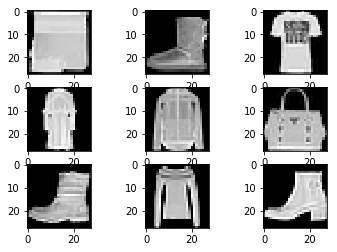

In [9]:
plot_data(x_train, random=True)

### Plot test data

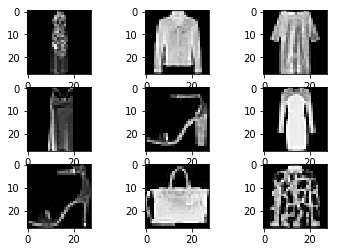

In [10]:
plot_data(x_test, random=True)

## Build Model

In [11]:
from keras.layers import Input, Dense
from keras.models import Model

#### Model-1: Feed Forward Network

In [12]:
input = Input(shape=[784])
# a layer instance is callable on a tensor, and returns a tensor
x = Dense(10, activation='tanh')(input)
x = Dense(7, activation='tanh')(x)
x = Dense(5, activation='tanh')(x)
x = Dense(4, activation='tanh')(x)
x = Dense(3, activation='tanh')(x)
predictions = Dense(num_classes, activation='softmax')(x)
# This creates a model that includes
# the Input layer and three Dense layers
model = Model(inputs=input, outputs=predictions)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                7850      
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 77        
_________________________________________________________________
dense_3 (Dense)              (None, 5)                 40        
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 24        
_________________________________________________________________
dense_5 (Dense)              (None, 3)                 15        
_________________________________________________________________
dense_6 (Dense)              (None, 10)                40        
Total para

#### Model-2 Convolution Neural Network

In [13]:
# # Model-2: val_acc: 92%
# # WARNING: Takes in the order of several hours to run 100+ epochs
# model = Sequential()
# model.add(Conv2D(32, kernel_size=(5, 5),
#                  activation='relu',
#                  input_shape=input_shape))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Conv2D(64, (5, 5), activation='relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))
# model.add(Flatten())
# model.add(Dense(1024, activation='relu'))
# model.add(Dropout(0.5))
# model.add(Dense(num_classes, activation='softmax'))
# model.summary()

### Build Information Plane

In [14]:
def tanh_activation(x):
    return np.tanh(x)

In [15]:
def softmax_activation(x):
    """Compute softmax values for each sets of scores in x."""
    e_x = np.exp(x - np.max(x))
    return e_x / e_x.sum(axis=0)

In [16]:
def hidden_layer(model, x, hidden):
    output = []
    if len(hidden) == 0:
        last_hidden = x;
        for i in range(1, len(all_layer_sizes)+1):
            w = model.layers[i].get_weights()[0]
            b = model.layers[i].get_weights()[1]
            input = np.matmul(last_hidden,w)+b
            if (i == len(all_layer_sizes)):
                last_hidden = softmax_activation(input)
            else:
                last_hidden = tanh_activation(input)
            output.append(last_hidden)
        hidden.append(output)        
    return hidden

In [17]:
def exctract_activity(batch_points_all, model, data_sets_org, hidden):
    w_temp = []
    for i in range(0, len(batch_points_all) - 1):
        batch_xs = data_sets_org.data[batch_points_all[i]:batch_points_all[i + 1]]
        batch_ys = data_sets_org.labels[batch_points_all[i]:batch_points_all[i + 1]]
        w_temp_local = hidden_layer(model, batch_xs, hidden)
        hidden = []
        for s in range(len(w_temp_local[0])):
            if i == 0:
                w_temp.append(w_temp_local[0][s])
            else:
                w_temp[s] = np.concatenate((w_temp[s], w_temp_local[0][s]), axis=0)
    return w_temp

In [18]:
def get_epoch_grads(model, batch_count):
    weights = model.trainable_weights # weight tensors
    weights = [weight for weight in weights] # filter down weights tensors to only ones which are trainable
    _gradients = model.optimizer.get_gradients(model.total_loss, weights) # gradient tensors
    
    input_tensors = [model.inputs[0], # input data
                     model.sample_weights[0], # how much to weight each sample by
                     model.targets[0], # labels
                     K.learning_phase(), # train or test mode
    ]

    get_gradients = K.function(inputs=input_tensors, outputs=_gradients)

    start = batch_size*batch_count
    end = start+batch_size
    _batch_size = batch_size
    if(start > x_train.shape[0]):
        start = x_train.shape[0]
        _batch_size = 32
    if(end > x_train.shape[0]):
        end = x_train.shape[0]
        _batch_size = 32
        
    #print(" size:",start,":",end)
    inputs = [x_train[start:end], # X
              np.ones(_batch_size), # sample weights
              y_train[start:end], # y
              0 # learning phase in TEST mode
    ]
    
    return get_gradients(inputs)

In [19]:
# Callback class to visialize training progress
class myCallbacks(keras.callbacks.History):
    def __init__(self):
        self.batch_count = 0
        self.epoch_count = 0
        self.k_count = 0
        self.epochs_grads = []
        self.hidden = []
        
    def on_epoch_begin(self, epoch, logs={}):
        if self.epoch_count in indexes:
            ws[self.k_count] = exctract_activity(batch_points_all, 
                                                 model, #self.model, 
                                                 data_sets_org, self.hidden)

    def on_epoch_end(self, epoch, logs={}):
        super(myCallbacks, self).on_epoch_end(epoch, logs)
        IPython.display.clear_output(wait=True)
        axes = pd.DataFrame(self.history).plot()
        axes.axvline(x=max((val_acc, i) for i, val_acc in enumerate(self.history['val_acc']))[1])
        pyplot.show()
        if self.epoch_count in indexes:
            if save_grads:
                gradients[self.k_count] = self.epochs_grads
            self.k_count += 1
        self.epochs_grads = []
        self.epoch_count = self.epoch_count + 1
        self.batch_count = 0
        self.hidden = []
        
    def on_batch_end(self, batch, logs={}):
        if self.epoch_count in indexes:
            epochs_grads_temp = get_epoch_grads(model, self.batch_count)
            self.epochs_grads.append(epochs_grads_temp)
        self.batch_count = self.batch_count + 1

In [20]:
def train_model(model):
    # Compile model with optimizer and loss function
    model.compile(loss='categorical_crossentropy',
              optimizer=adam(lr=0.001),
              metrics=['accuracy'])
    
    # Train model
    model.fit(x_train,y_train,
          batch_size=batch_size, 
          epochs=num_ephocs,
          verbose=True,
          validation_data=(x_test, y_test),callbacks=[myCallbacks()])

### Evaluate model

In [21]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=pyplot.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    pyplot.imshow(cm, interpolation='nearest', cmap=cmap)
    pyplot.title(title)
    pyplot.colorbar()
    tick_marks = np.arange(len(classes))
    pyplot.xticks(tick_marks, classes, rotation=45)
    pyplot.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        pyplot.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    pyplot.tight_layout()
    pyplot.ylabel('True label')
    pyplot.xlabel('Predicted label')

In [22]:
def evaluate_and_predict(model):
    score = model.evaluate(x_test, y_test, verbose=0)
    print('Test loss:', score[0])
    print('Test accuracy:', score[1])
    
    # predict y_hat
    y_pred = model.predict(x_test)
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(np.argmax(y_test, axis=1), np.argmax(y_pred, axis=1))

    np.set_printoptions(precision=2)

    class_names = ["T-shirt","Trouser","Pullover","Dress","Coat","Sandal","Shirt","Sneaker","Bag","Ankle boot"]

    # Plot non-normalized confusion matrix
    pyplot.figure()
    plot_confusion_matrix(cnf_matrix, classes=class_names,
                          title='Confusion matrix, without normalization')

    pyplot.show()

### Train and Obtain INFORMATION PLANE

In [23]:
def train_and_calc_inf_network(i, j, k, model):
    print("train_and_calc:(i,j,k):",i,j,k)
    train_model(model)
    evaluate_and_predict(model)
    print("Done train network...")
    network = {}
    network['ws'] = ws
    network['test_prediction'] = test_prediction
    network['train_prediction'] = train_prediction
    network['loss_test'] = loss_func_test
    network['loss_train'] = loss_func_train
    network['gradients'] = gradients
    network['model'] = model
    network['information'] = []
    print ('Calculating the infomration')
    infomration = np.array([inn.get_information(network['ws'], data_sets_org.data, data_sets_org.labels,
                                                num_of_bins, interval_information_display, network['model'],
                                                layerSize,calc_parallel=False)])
    network['information'] = infomration
    return network

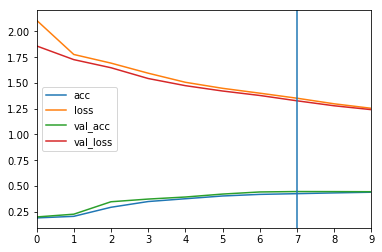

52000/52000 [==============================] - 7s - loss: 1.2537 - acc: 0.4389 - val_loss: 1.2406 - val_acc: 0.4438
Test loss: 1.24059372352
Test accuracy: 0.443769230769
Confusion matrix, without normalization
[[ 237  791   68  128   34    7   29    0    7    0]
 [  14 1233   15   20    5    1    7    0    0    0]
 [   7    7  583   36  599    2   37    0   14    0]
 [ 384  267  149  349   40    5   97    0    2    0]
 [   5    1  375   37  864    7   29    0   12    0]
 [   0    0    1    0   11 1108    0   28   51  113]
 [  98  102  247  176  604    7   29    0   14    0]
 [   0    0    0    0    0   75    0   32   14 1156]
 [   5    2    9    6   80 1100    1    0  106   13]
 [   0    0    0    0    0   46    0   28    6 1228]]


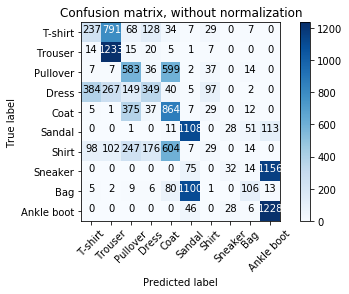

Done train network...
Calculating the infomration
Start calculating the information...
Calculated The information of epoch number - 0
0


ValueError: cannot copy sequence with size 9 to array axis with dimension 10

In [24]:
results = [train_and_calc_inf_network(i, j, k, model) 
           for i in range(len(train_samples)) 
           for j in range(len(layers_sizes)) 
           for k in range(num_of_repeats)]

# Extract all the measures and orgainze it
for i in range(len(train_samples)):
    for j in range(len(layers_sizes)):
        for k in range(num_of_repeats):
            index = i * len(layers_sizes) * num_of_repeats + j * num_of_repeats + k
            print(index)
            current_network = results[index]
            networks[k][j][i] = current_network
            ws[k][j][i] = current_network['ws']
            weights[k][j][i] = current_network['weights']
            information[k][j][i] = current_network['information']
            grads[k][i][i] = current_network['gradients']
            test_error[k, j, i, :] = current_network['test_prediction']
            train_error[k, j, i, :] = current_network['train_prediction']
            loss_test[k, j, i, :] = current_network['loss_test']
            loss_train[k, j, i, :] = current_network['loss_train']
traind_network = True

In [55]:
current_network['information']

array([[[{'local_IXT': -0.0, 'local_ITY': -0.0},
         {'local_IXT': -0.0, 'local_ITY': -0.0},
         {'local_IXT': -0.0, 'local_ITY': -0.0},
         {'local_IXT': -0.0, 'local_ITY': -0.0},
         {'local_IXT': -0.0, 'local_ITY': -0.0},
         {'local_IXT': -0.0, 'local_ITY': -0.0}],
        [{'local_IXT': 3.6162282670167589, 'local_ITY': 1.2363572186787071},
         {'local_IXT': 5.732860514997828, 'local_ITY': 1.4296621067816693},
         {'local_IXT': 6.1901087979638199, 'local_ITY': 1.3431735446973017},
         {'local_IXT': 5.6282958012079716, 'local_ITY': 1.2504462667067306},
         {'local_IXT': 4.0637676498198472, 'local_ITY': 1.1772523818250242},
         {'local_IXT': -0.0, 'local_ITY': -0.0}],
        [{'local_IXT': 3.9938583025923919, 'local_ITY': 1.345030390336182},
         {'local_IXT': 6.1192942950282179, 'local_ITY': 1.5981450977798479},
         {'local_IXT': 6.4308172391547025, 'local_ITY': 1.4606780290989168},
         {'local_IXT': 5.6535691894913143

In [61]:
current_network['ws']

[[array([[ -6.57e-03,  -5.13e-03,  -2.71e-03, ...,  -6.49e-04,  -1.69e-03,
            6.41e-03],
         [ -3.20e-03,  -4.35e-03,  -3.16e-04, ...,  -1.31e-03,  -7.83e-04,
            1.52e-03],
         [ -1.48e-03,  -4.11e-04,  -1.47e-03, ...,   1.75e-03,  -9.19e-04,
            1.80e-04],
         ..., 
         [ -1.89e-03,  -2.33e-03,  -2.45e-03, ...,  -1.10e-03,   9.95e-04,
            2.42e-03],
         [ -2.84e-03,   3.07e-05,   2.25e-03, ...,   1.18e-03,  -2.37e-04,
            2.86e-03],
         [ -5.94e-05,   8.86e-05,  -1.65e-03, ...,   5.82e-04,  -1.23e-04,
            1.90e-03]], dtype=float32),
  array([[  8.73e-03,  -3.14e-03,   4.30e-03, ...,   6.96e-03,   3.84e-03,
           -9.43e-04],
         [  4.29e-03,  -5.71e-04,   1.98e-03, ...,   4.22e-03,  -4.50e-04,
           -3.24e-03],
         [  4.03e-03,  -2.23e-03,   2.03e-03, ...,   5.98e-04,   3.61e-04,
           -1.33e-03],
         ..., 
         [  3.05e-03,  -3.39e-05,   2.09e-03, ...,   2.00e-03,   1.12e-

In [56]:
current_network['gradients']

[[[array([[ -8.15e-08,  -4.61e-08,  -2.20e-08, ...,  -2.90e-08,  -1.02e-07,
            -4.33e-08],
          [ -8.15e-08,  -4.61e-08,  -2.20e-08, ...,  -2.90e-08,  -1.02e-07,
            -4.33e-08],
          [ -8.15e-08,  -4.61e-08,  -2.20e-08, ...,  -2.90e-08,  -1.02e-07,
            -4.33e-08],
          ..., 
          [ -3.45e-06,  -3.39e-06,  -9.57e-06, ...,  -1.05e-06,  -5.13e-06,
            -1.80e-06],
          [ -8.92e-08,  -6.21e-07,  -9.82e-07, ...,   2.73e-08,  -3.58e-07,
             2.28e-08],
          [ -5.61e-08,  -3.17e-08,  -1.51e-08, ...,  -1.99e-08,  -7.00e-08,
            -2.98e-08]], dtype=float32),
   array([-0.01, -0.01, -0.02,  0.02, -0.01,  0.01, -0.  , -0.  , -0.02, -0.01], dtype=float32),
   array([[ -2.69e-06,  -3.22e-05,  -2.85e-05,  -1.77e-05,  -3.79e-05,
             2.55e-05,   6.05e-06],
          [  3.44e-05,  -1.13e-04,  -3.92e-05,  -7.72e-05,  -1.13e-04,
             4.27e-05,   2.01e-06],
          [  2.25e-05,  -6.29e-06,   3.19e-06,   6.99e-0

### Save Information Plane Parameters

In [ ]:
params = {'sampleLen': len(train_samples),
          'nDistSmpls': 1,
          'layerSizes': ",".join(str(i) for i in layers_sizes[0]), 'nEpoch': num_ephocs, 'batch': batch_size,
          'nRepeats': num_of_repeats, 'nEpochInds': len(epochs_indexes),
          'LastEpochsInds': epochs_indexes[-1], 'DataName': 'var_u',
          'lr': learning_rate}
name = 'net'
NUM_CORES = multiprocessing.cpu_count()
name_to_save = name + "_" + "_".join([str(i) + '=' + str(params[i]) for i in params])
params['train_samples'], params['CPUs'], params[
    'directory'], params['epochsInds'] = train_samples, NUM_CORES, name_to_save, epochs_indexes


In [ ]:
def save_data(parent_dir='jobs/', file_to_save='data.pickle'):
    """Save the data to the file """
    directory = '{0}/{1}{2}/'.format(os.getcwd(), parent_dir, params['directory'])

    data = {'information': information,
            'test_error': test_error, 'train_error': train_error, 'var_grad_val': grads,
            'loss_test': loss_test, 'loss_train': loss_train, 'params': params, 
            'l1_norms': l1_norms, 'weights': weights, 'ws': ws}

    if not os.path.exists(directory):
        os.makedirs(directory)
    dir_saved = directory
    with open(dir_saved + file_to_save, 'wb') as f:
        cPickle.dump(data, f, protocol=2)
    return dir_saved

In [ ]:
print ('Saving data')
dir_saved = save_data()

### Plot Figures

In [ ]:
print ('Ploting figures')
#Plot the newtork
str_names = [[dir_saved]]
mode = 2
save_name = 'figure'
plt_fig.plot_figures(str_names, mode, save_name)